In [39]:
import os
import random
from PIL import Image
import torch
from diffusers import StableDiffusionInpaintPipeline
import transformers
import matplotlib.pyplot as plt

CONFIG

In [40]:
MODEL_ID = "sd-legacy/stable-diffusion-inpainting"
STRENGTH = 0.7
GUIDANCE_SCALE = 7.5
NUM_INFERENCE_STEPS = 30
OBJECT_NUMBER = 5

IMAGE_COUNT = 10

In [41]:
device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    MODEL_ID,
    torch_dtype=torch.float16
)
pipe = pipe.to(device)
pipe.enable_attention_slicing()

Loading pipeline components...:  29%|██▊       | 2/7 [00:00<00:01,  2.73it/s]An error occurred while trying to fetch C:\Users\super\.cache\huggingface\hub\models--sd-legacy--stable-diffusion-inpainting\snapshots\8a4288a76071f7280aedbdb3253bdb9e9d5d84bb\unet: Error no file named diffusion_pytorch_model.safetensors found in directory C:\Users\super\.cache\huggingface\hub\models--sd-legacy--stable-diffusion-inpainting\snapshots\8a4288a76071f7280aedbdb3253bdb9e9d5d84bb\unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Loading pipeline components...:  86%|████████▌ | 6/7 [00:01<00:00,  3.48it/s]An error occurred while trying to fetch C:\Users\super\.cache\huggingface\hub\models--sd-legacy--stable-diffusion-inpainting\snapshots\8a4288a76071f7280aedbdb3253bdb9e9d5d84bb\vae: Error no file named diffusion_pytorch_model.safetensors found in directory C:\Users\super\.cache\huggingface\hub\models--sd-legacy--stable-diffusion-inpainting\snapshots\8a4288a

In [42]:
def check_overlap(new_rect, occupied_rects):
    """Check if new_rect overlaps any existing rectangles"""
    x1, y1, x2, y2 = new_rect
    for ox1, oy1, ox2, oy2 in occupied_rects:
        # Check for rectangle overlap
        if not (x2 <= ox1 or x1 >= ox2 or y2 <= oy1 or y1 >= oy2):
            return True
    return False

In [43]:
# Paths
backgrounds_folder = "../GenerationData/Backgrounds"
objects_folder = "../GenerationData/Objects"
prompts_file = "../GenerationData/prompts.txt"

# Results paths
generatedImagesFolder = "../Datasets/GeneratedImages"
generatedMasksFolder = "../Datasets/GeneratedMasks"

# Load file paths
backgrounds = [os.path.join(backgrounds_folder, f) for f in os.listdir(backgrounds_folder)
               if f.lower().endswith((".png", ".jpg", ".jpeg"))]
objects = [os.path.join(objects_folder, f) for f in os.listdir(objects_folder)
           if f.lower().endswith((".png", ".jpg", ".jpeg"))]

prompts = []
# Each line new prompt
with open(prompts_file, "r") as f:
    prompts = f.read().splitlines()

In [44]:
inpainted = None
for i in range(IMAGE_COUNT):
    # Pick one random background
    bg_path = random.choice(backgrounds)
    background = Image.open(bg_path).convert("RGBA")

    # Randomly rotate the background (90, 180, or 270 degrees)
    rotation_angle = random.choice([0, 90, 180, 270])
    background = background.rotate(rotation_angle, expand=False)

    # Create a blank black mask
    mask = Image.new("L", background.size, 0)

    # Random number of objects
    num_objects = random.randint(1, OBJECT_NUMBER)
    chosen_objects = random.sample(objects, num_objects)

    occupied = []
    for obj_path in chosen_objects:
        obj = Image.open(obj_path).convert("RGBA")
        obj_width, obj_height = obj.width, obj.height

        # Try to place object without overlapping (limit attempts)
        max_attempts = 100
        for attempt in range(max_attempts):
            max_x = background.width - obj_width
            max_y = background.height - obj_height
            pos = (random.randint(0, max_x), random.randint(0, max_y))
            new_rect = (pos[0], pos[1], pos[0] + obj_width, pos[1] + obj_height)

            if not check_overlap(new_rect, occupied):
                # Place object
                background.alpha_composite(obj, pos)
                # Update mask
                obj_mask = obj.split()[-1]  # alpha channel
                mask.paste(obj_mask, pos, obj_mask)
                # Add to occupied
                occupied.append(new_rect)
                break
        else:
            print(f"Could not place {obj_path} without overlap after {max_attempts} attempts.")

    # Reverse Mask for backgrounds (comment out for objects or if data is reversed)
    reverse_mask = Image.eval(mask, lambda p: 255 - p)
    composite_rgb = background.convert("RGB")

    # Choose random prompt
    prompt = random.choice(prompts)
    # Generation
    result = pipe(
        prompt=prompt,
        image=composite_rgb,
        mask_image=reverse_mask,
        guidance_scale=GUIDANCE_SCALE,
        strength=STRENGTH,
        num_inference_steps=NUM_INFERENCE_STEPS,
    )

    inpainted = result.images[0]

    # Create folders if don't exist
    os.makedirs(generatedImagesFolder, exist_ok=True)
    os.makedirs(generatedMasksFolder, exist_ok=True)
    # Save
    inpainted.save(os.path.join(generatedImagesFolder, f"{i}.png"))
    mask.save(os.path.join(generatedMasksFolder, f"{i}.png"))

Token indices sequence length is longer than the specified maximum sequence length for this model (137 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['dry grass and subtle natural texture , and the trees should appear realistic from above , with visible tree canopies . the lighting is soft and natural , resembling early morning with no harsh shadows just gentle light falling directly down from above , as seen from a drone . top - down view , realistic view']
100%|██████████| 21/21 [00:01<00:00, 14.69it/s]
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['dry grass and subtle natural texture , and the trees should appear realistic from above , with visible tree canopies . the lighting is soft and natural , resembling early morning with no harsh shadows just gentle light falling directly down from abo

RUN THIS BELOW JUST TO CHECK OR TEST

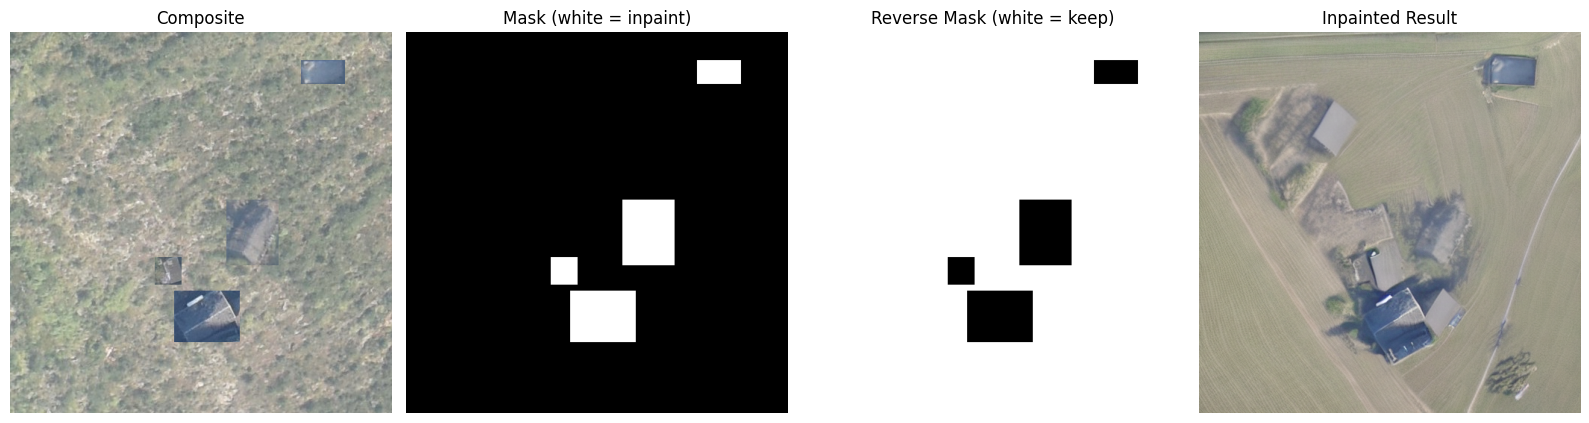

In [38]:
fig, axs = plt.subplots(1, 4, figsize=(16, 5))
axs[0].imshow(composite_rgb)
axs[0].set_title(f"Composite")
axs[0].axis("off")

axs[1].imshow(mask, cmap="gray")
axs[1].set_title("Mask (white = inpaint)")
axs[1].axis("off")

axs[2].imshow(reverse_mask, cmap="gray")
axs[2].set_title("Reverse Mask (white = keep)")
axs[2].axis("off")

axs[3].imshow(inpainted)
axs[3].set_title("Inpainted Result")
axs[3].axis("off")

plt.tight_layout()
plt.show()